In [1]:
# this is written one month before the first working game prototype
# code needs to be updated
# this is largely for demostration and to appreciate why picking peaks in the first octave don't usually work
from IPython.display import clear_output

import pyaudio
import argparse

import numpy as np
import time
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def setup_classifier(model_path, weight_path):
    yaml_file = open(model_path, 'r')
    loaded = yaml_file.read()
    yaml_file.close()
    classifier = keras.models.model_from_yaml(loaded)
    classifier.load_weights(weight_path)
    return classifier

classifier = setup_classifier(model_path="model.yaml", weight_path="weight-25800-CNN_E_good.hdf5")
# Loading the classifier takes time. It should not be done every time when the program runs.

In [3]:
def predict(data, classifier):
    result = classifier.predict(data)[0].tolist()
    output = 'C'
    possible = 'possible notes: '
    for i in range(len(result)):
        if result[i] < 0.01:
            result[i] = 0
        elif result[i] > 0.99:
            result[i] = 1
            output += '_{}'.format(i+60)
        else:
            possible += '_{}__{}'.format(i+60, result[i])
    print(output)
    print(possible)
    return result

In [4]:
import librosa
def convert_to_CQT(signal_to_map):
    fmin = librosa.core.note_to_hz("B3")
    cqt_array = librosa.cqt(signal_to_map, sr=44100, hop_length=2**7, bins_per_octave=36, fmin=fmin, n_bins=108)
    CQT = librosa.magphase(cqt_array)[0][:108,-108:]
    print(np.shape(CQT))
    return CQT

In [5]:
# this is the size of each individual block of audio, we call this "chunk"
chunksize = 2048

# todo: variable frequency for CQT

# parser = argparse.ArgumentParser()
# parser.add_argument("-input", required=False, type=int, help="Audio Input Device")
# args = parser.parse_args()

# # this is here so you can choose the default audio input
# if args.input is None:
#     print("No input device specified. Printing list of input devices now: ")
#     p = pyaudio.PyAudio()
#     for i in range(p.get_device_count()):
#         print("Device number (%i): %s" % (i, p.get_device_info_by_index(i).get('name')))
#         print("Run this program with -input 1, or the number of the input you'd like to use.")
#         exit()

# starting audio channel?
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32,
channels=1, rate=44100, input=True,
input_device_index=0, frames_per_buffer=chunksize)
time.sleep(1)

In [6]:
def detect_onset(signal, chunksize=2048, tempo_res=32, plotting = False):
    '''
    # this is to be called at the end of every chunk (2048 entries), starting from 4th chunk
    # the input to this function is four chunks
    These are never likely to be changed, maybe? : chunksize=2048, tempo_res=32
    
    TODO: make become on the fly
    '''
    # default value of onset, overwritten if onset is detected
    onset = -1

    # to detect difference
    difference = np.cumsum(np.add(np.absolute(signal[chunksize:-chunksize]), -np.absolute(signal[:-2*chunksize])))
    
    # white noise is added the the difference 
    # this is to desensitise detection of low amplitdue onset sounds
    noise = 10*np.array(np.random.randn(len(difference)))
    difference = np.add(difference, noise)

    # calculation of r-coefficient
    # -1 is negatively correlated
    # +1 is positively correlated
    # onset is when r-coefficient cuts above 0.8
    roceff = np.full(tempo_res, 0.)
    tempo_num = int(chunksize / tempo_res)
    for i in range(tempo_res):
#         print(np.shape(difference))
        roceff[i] = np.corrcoef(difference[i * tempo_num:(i * tempo_num + chunksize)],
                                      np.arange(chunksize))[0, 1]
        # special case when i = 0, because we do not have the previous value
#         if i == 0 and roceff[0] > 0.8:
#             onset = i
        if roceff[0] < 0.8 and roceff[i] > 0.8 and np.max(roceff[:i]) < 0.8:
            onset = i
    
    if onset != -1:
        # clear output from jupyter
        clear_output(wait=True)
        plt.figure(figsize=(16,2))
        plt.plot(np.arange(2048*1,2048*3),np.array(difference)/np.max(difference))
        plt.plot(np.arange(2048*2,2048*3,64),roceff)
        plt.plot(signal)
        plt.axvline(x=2048*1+64*onset, color="r")
        plt.axvline(x=2048*3+64*onset, color="r")
        plt.show()
    return onset # none, or a value

In [7]:
def note_detect(chunksize=2048, tempo_res=32, plotting = False):
    print("opening")
    frames = []
    i = 0

    while True:
        # assume pyaudio clip mono sound
        # use assert?
        
        i += 1
        data = stream.read(chunksize, exception_on_overflow=False)
        data = np.fromstring(data, np.float32)
        frames.append(data)
        # print(len(frames))
        
        # start listening only after there is a certain number of "frames"
        if i > 10 and len(frames)>4:
            frames[:] = frames[-10:]
            signal = np.concatenate((frames[-5],frames[-4],frames[-3],frames[-2]))

            # onset function
            # print(np.sum(abs(signal)))
            # print(len(signal))
            # print("finding onset")
            onset = detect_onset(signal)
            # print("onset detection complete")
            # print(onset)
            
            # remove the older frames
            
            
            # make an array consists of 4096 entries if there is an onset
            if onset != -1:
                print("onset DETECTED")
                signal_ = np.concatenate((frames[-10],frames[-9],
                                          frames[-8],frames[-7],
                                          frames[-6],frames[-5],
                                          frames[-4],frames[-3],
                                          frames[-2],frames[-1]))
                signal_input = signal_[-4*4096+64*onset:-2048+64*onset]
                onset = -1 # set onset back to negative one - but necessary?
                
                spectro = convert_to_CQT(signal_input)
                
                plt.imshow(spectro)
                plt.show()
                
                spectro = spectro.reshape(1,108,108,1)
                print(np.shape(spectro))
                result = predict(spectro, classifier)
                print(result)

    # don't you need to return something?

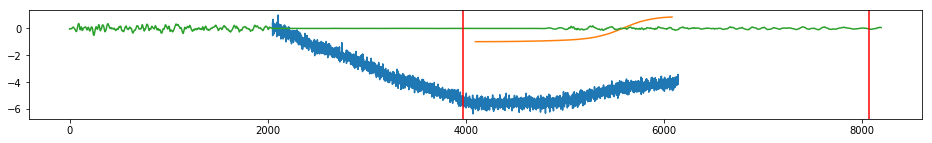

onset DETECTED
(108, 108)


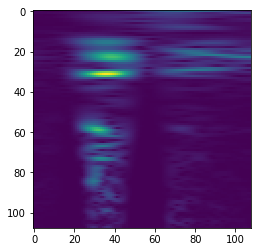

(1, 108, 108, 1)
C_60_63
possible notes: 
[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


KeyboardInterrupt: 

In [8]:
note_detect()